## Basic Steps

1. Run a baseline training script to build a speech commands model.
2. Add in your custom word to the training and test/validation sets.
   - Modify labels, shape of your output tensor in the model.
   - Make sure that feature extractor for the model aligns with the feature extractor 
     used in the arduino code.
3. Re-train model. => TF Model using floating-point numbers, that recognizes Google word and custom word.
4. Quantize the model and convert to TFlite. => keyword_model.tflite file
5. Convert tflite to .c file, using xxd => model_data.cc
6. Replace contents of existing micro_features_model.cpp with output of xxd.

All of the above steps are done in this notebook for the commands 'left', 'right'.

7. In micro_speech.ino, modify micro_op_resolver (around line 80) to add any necessary operations (DIFF_FROM_LECTURE)
8. In micro_features_model_settings.h, modify kSilenceIndex and kUnknownIndex, depending on 
where you have them in commands.  
  - Commands = ['left', 'right', '_silence', '_unknown'] => kSilenceIndex=2, kUnknownIndex=3
9. In micro_features_model_settings.cpp, modify kCategoryLabels to correspond to commands in this script.
10. In micro_features_micro_model_settings.h, set kFeatureSliceDurationMs, kFeatureSliceStrideMs to match what is passed to microfrontend as window_size, window_step, respectively.
11. Rebuild Arduino program, run it, recognize the two target words.
12. Experiment with model architecture, training parameters/methods, augmentation, more data-gathering, etc.

*Note*:  As of 5/3/21, this model uses 22% of flash and 49.5% of RAM, so there is substantial space to improve the model, but the latency is about 208ms, which is probably too slow.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
import keras
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
# from tqdm import tqdm # replace with this if moving out of notebook

import os
import pathlib

from datetime import datetime as dt

from IPython import display

2.10.1


In [2]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
wave_length_ms = 1000
wave_length_samps = int(wave_length_ms*fsamp/1000)
window_size_ms=60
window_step_ms=40
num_filters = 32
use_microfrontend = True
dataset = 'mini-speech'
#dataset = 'full-speech-ds' # use the full speech commands as a pre-built TF dataset 
#dataset = 'full-speech-files' # use the full speech commands stored as files 

silence_str = "_silence"  
unknown_str = "_unknown"
EPOCHS = 25

Apply the frontend to an example signal.

In [4]:
%pwd

'c:\\Users\\micha\\Documents\\College\\UNCC\\Spring-2023\\ML_for_IoT-5127\\HW\\project2'

In [5]:
data_dir = pathlib.Path(os.path.join(os.getcwd(), 'data/mini_speech_commands'))
print(data_dir.exists())

True


In [6]:
commands = ['stop', 'sponge'] 
if dataset == 'mini-speech':
  data_dir = pathlib.Path(os.path.join(os.getcwd(), 'data/mini_speech_commands'))
  if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip',
          origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
          extract=True, cache_dir='.', cache_subdir='data')
  # commands = np.array(tf.io.gfile.listdir(str(data_dir))) # if you want to use all the command words
  # commands = commands[commands != 'README.md']
elif dataset == 'full-speech-files':
  # data_dir = '/dfs/org/Holleman-Coursework/data/speech_dataset'
  data_dir = pathlib.Path(os.path.join(os.getenv("HOME"), 'data/speech_commands_files_0.2'))

elif dataset == 'full-speech-ds':
    raise RuntimeError("full-speech-ds is not really supported yet")

In [7]:
data_dir

WindowsPath('c:/Users/micha/Documents/College/UNCC/Spring-2023/ML_for_IoT-5127/HW/project2/data/mini_speech_commands')

In [83]:
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'stop', 'sponge']


In [9]:
if dataset == 'mini-speech' or dataset == 'full-speech-files':
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav') 
    # with the next commented-out line, you can choose only files for words in label_list
    # filenames = tf.concat([tf.io.gfile.glob(str(data_dir) + '/' + cmd + '/*') for cmd in label_list], 0)
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    # print('Number of examples per label:',
    #       len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
    print('Example file tensor:', filenames[0])

Number of total examples: 10009
Example file tensor: tf.Tensor(b'c:\\Users\\micha\\Documents\\College\\UNCC\\Spring-2023\\ML_for_IoT-5127\\HW\\project2\\data\\mini_speech_commands\\up\\fb9d6d23_nohash_0.wav', shape=(), dtype=string)


In [10]:
filenames
# tf.strings.split(filenames[0], os.path.sep)[-2].numpy().decode('utf8')

<tf.Tensor: shape=(10009,), dtype=string, numpy=
array([b'c:\\Users\\micha\\Documents\\College\\UNCC\\Spring-2023\\ML_for_IoT-5127\\HW\\project2\\data\\mini_speech_commands\\up\\fb9d6d23_nohash_0.wav',
       b'c:\\Users\\micha\\Documents\\College\\UNCC\\Spring-2023\\ML_for_IoT-5127\\HW\\project2\\data\\mini_speech_commands\\sponge\\sponge_Sample10_Noise5_Multiplier2.wav',
       b'c:\\Users\\micha\\Documents\\College\\UNCC\\Spring-2023\\ML_for_IoT-5127\\HW\\project2\\data\\mini_speech_commands\\go\\37dca74f_nohash_4.wav',
       ...,
       b'c:\\Users\\micha\\Documents\\College\\UNCC\\Spring-2023\\ML_for_IoT-5127\\HW\\project2\\data\\mini_speech_commands\\left\\bfb10243_nohash_0.wav',
       b'c:\\Users\\micha\\Documents\\College\\UNCC\\Spring-2023\\ML_for_IoT-5127\\HW\\project2\\data\\mini_speech_commands\\right\\f44f440f_nohash_0.wav',
       b'c:\\Users\\micha\\Documents\\College\\UNCC\\Spring-2023\\ML_for_IoT-5127\\HW\\project2\\data\\mini_speech_commands\\sponge\\sponge_Sample15

In [11]:
# Not really necessary, but just look at a few of the files to make sure that 
# they're the correct files, shuffled, etc.
for i in range(10):
    print(filenames[i].numpy().decode('utf8'))

c:\Users\micha\Documents\College\UNCC\Spring-2023\ML_for_IoT-5127\HW\project2\data\mini_speech_commands\up\fb9d6d23_nohash_0.wav
c:\Users\micha\Documents\College\UNCC\Spring-2023\ML_for_IoT-5127\HW\project2\data\mini_speech_commands\sponge\sponge_Sample10_Noise5_Multiplier2.wav
c:\Users\micha\Documents\College\UNCC\Spring-2023\ML_for_IoT-5127\HW\project2\data\mini_speech_commands\go\37dca74f_nohash_4.wav
c:\Users\micha\Documents\College\UNCC\Spring-2023\ML_for_IoT-5127\HW\project2\data\mini_speech_commands\go\988e2f9a_nohash_1.wav
c:\Users\micha\Documents\College\UNCC\Spring-2023\ML_for_IoT-5127\HW\project2\data\mini_speech_commands\yes\0f7dc557_nohash_0.wav
c:\Users\micha\Documents\College\UNCC\Spring-2023\ML_for_IoT-5127\HW\project2\data\mini_speech_commands\up\f33660af_nohash_1.wav
c:\Users\micha\Documents\College\UNCC\Spring-2023\ML_for_IoT-5127\HW\project2\data\mini_speech_commands\right\b87bdb22_nohash_4.wav
c:\Users\micha\Documents\College\UNCC\Spring-2023\ML_for_IoT-5127\HW\pro

In [12]:
if dataset == 'mini-speech':
  print('Using mini-speech')
  num_train_files = int(0.8*num_samples) 
  num_val_files = int(0.1*num_samples) 
  num_test_files = num_samples - num_train_files - num_val_files
  train_files = filenames[:num_train_files]
  val_files = filenames[num_train_files: num_train_files + num_val_files]
  test_files = filenames[-num_test_files:]
elif dataset == 'full-speech-files':  
  # the full speech-commands set lists which files are to be used
  # as test and validation data; train with everything else
  fname_val_files = os.path.join(data_dir, 'validation_list.txt')    
  with open(fname_val_files) as fpi_val:
    val_files = fpi_val.read().splitlines()
  # validation_list.txt only lists partial paths
  val_files = [os.path.join(data_dir, fn) for fn in val_files]
  fname_test_files = os.path.join(data_dir, 'testing_list.txt')

  with open(fname_test_files) as fpi_tst:
    test_files = fpi_tst.read().splitlines()
  # testing_list.txt only lists partial paths
  test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]    

  # convert the TF tensor filenames into an array of strings so we can use basic python constructs
  train_files = [f.decode('utf8') for f in filenames.numpy()]
  # don't train with the _background_noise_ files; exclude when directory name starts with '_'
  train_files = [f for f in train_files if f.split('/')[-2][0] != '_']
  # validation and test files are listed explicitly in *_list.txt; train with everything else
  train_files = list(set(train_files) - set(test_files) - set(val_files))
  # now convert back into a TF tensor so we can use the tf.dataset pipeline
  train_files = tf.constant(train_files)    
  print("full-speech-files is in progress.  Good luck!")
elif dataset == 'full-speech-ds':  
    print("Using full-speech-ds. This is in progress.  Good luck!")
else:
  raise ValueError("dataset must be either full-speech-files, full-speech-ds or mini-speech")
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Using mini-speech
Training set size 8007
Validation set size 1000
Test set size 1002


In [13]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [14]:
# @tf.function
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  in_set = tf.reduce_any(parts[-2] == label_list)
  label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return  label #parts[-2]

In [15]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [17]:
def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
  return spectrogram


Function to convert each waveform in a set into a spectrogram, then convert those
back into a dataset using `from_tensor_slices`.  (We should be able to use 
`wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).
   

In [18]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))  

In [19]:
def wavds2specds(waveform_ds, verbose=True):
  wav, label = next(waveform_ds.as_numpy_iterator())
  one_spec = get_spectrogram(wav)
  one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
  one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

  num_waves = 0 # count the waveforms so we can allocate the memory
  for wav, label in waveform_ds:
    num_waves += 1
  print(f"About to create spectrograms from {num_waves} waves")
  spec_shape = (num_waves,) + one_spec.shape[1:] 
  spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
  labels = np.nan * np.zeros(num_waves)
  idx = 0
  for wav, label in waveform_ds:    
    if verbose and idx % 250 == 0:
      print(f"\r {idx} wavs processed", end='')
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams[idx, ...] = spectrogram
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == np.array(label_list))    
    labels[idx] = new_label_id # for numeric labels
    # labels.append(new_label) # for string labels
    idx += 1
  labels = np.array(labels, dtype=int)
  output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
  return output_ds

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

About to create spectrograms from 8007 waves
 8000 wavs processed

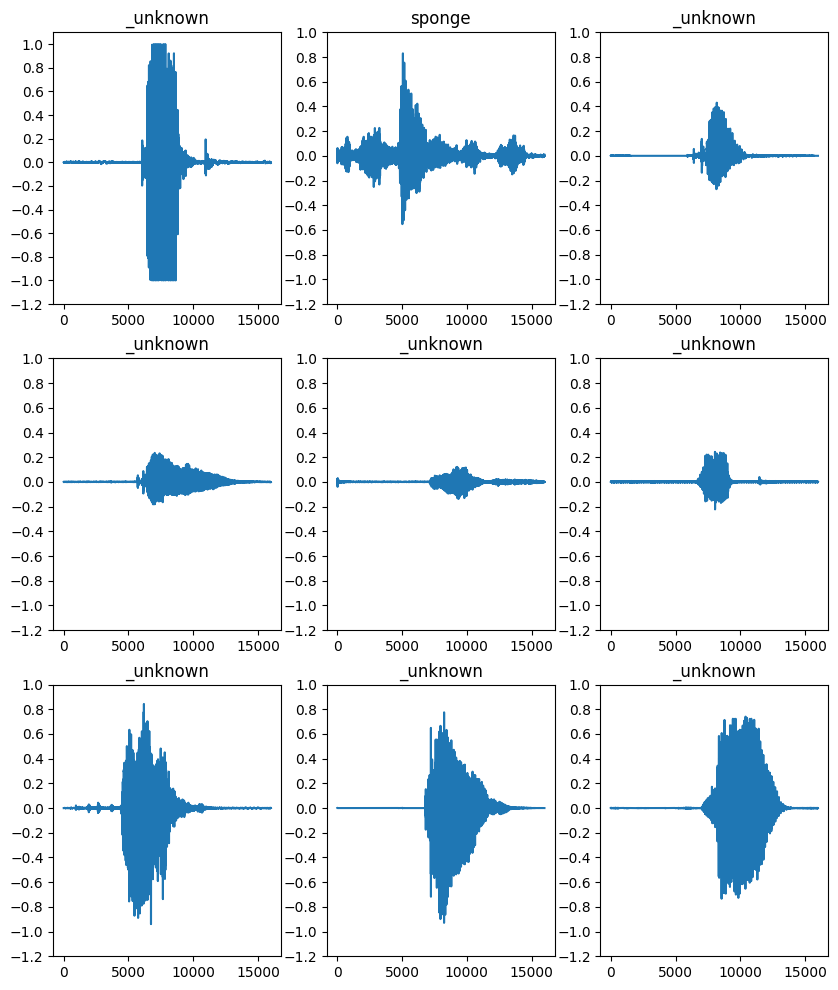

In [21]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [22]:
for waveform, label in waveform_ds.take(2):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: sponge
Waveform shape: (16000,)
Spectrogram shape: (24, 32)
Audio playback


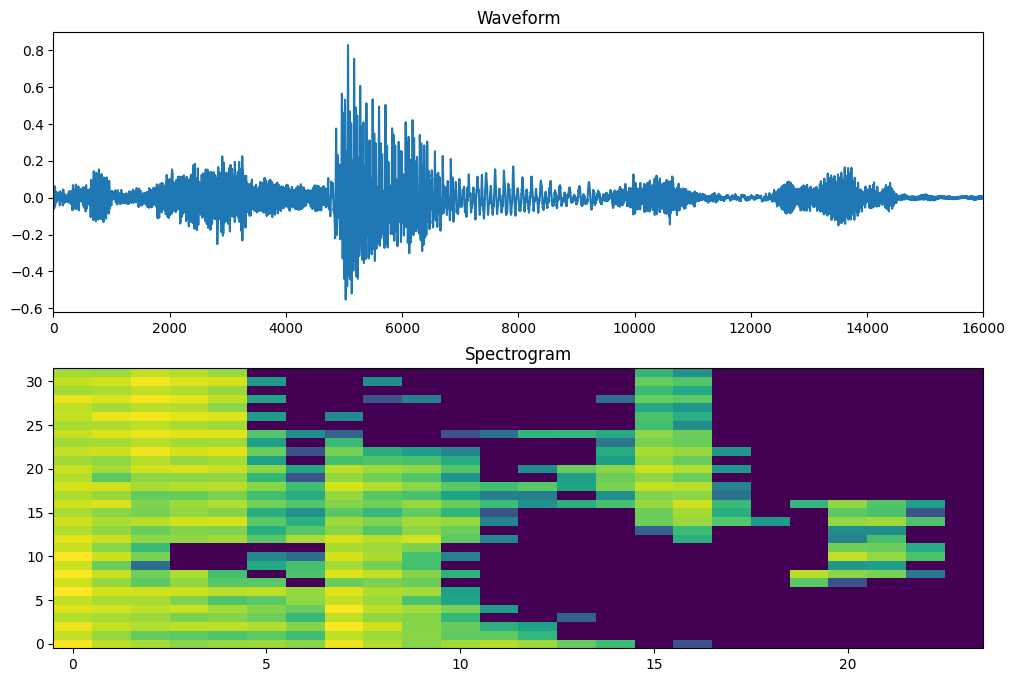

In [23]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [24]:
spectrogram.numpy().shape

(24, 32)

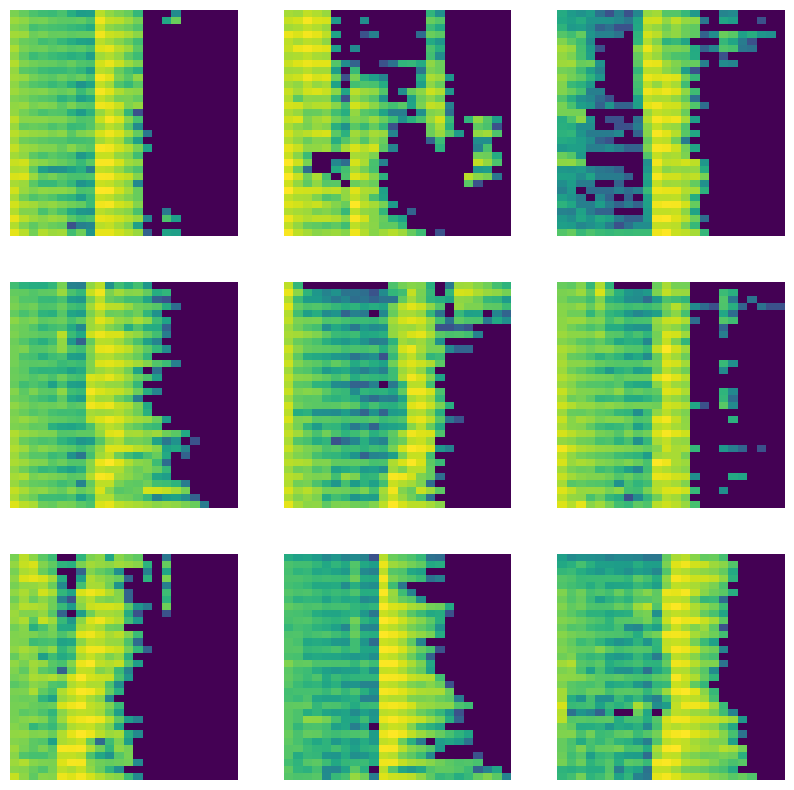

In [25]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  #ax.set_title(label_list[np.int(label_id)])
  ax.axis('off')

plt.show()

In [26]:
def copy_with_noise(ds_input, rms_level=0.25):
  rng = tf.random.Generator.from_seed(1234)
  wave_shape = tf.constant((wave_length_samps,))
  def add_noise(waveform, label):
    noise = rms_level*rng.normal(shape=wave_shape)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)    
    noisy_wave = waveform + noise
    return noisy_wave, label

  return ds_input.map(add_noise)

In [27]:
# waveform_ds = augment_with_noise(waveform_ds)
count = 0
for w,l in waveform_ds:
  if w.shape != (16000,):
    print(f"element {count} has shape {w.shape}")
    break
  count += 1
print(count)

element 17 has shape (15604,)
17


In [28]:
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

In [29]:
def count_labels(dataset):
    counts = {}
    for _, lbl in dataset:
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [30]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  # if noisy_reps_of_known is not None, it should be a list of rms noise levels
  # For every target word in the data set, 1 copy will be created with each level 
  # of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
  if num_silent is None:
    num_silent = int(0.2*len(files))+1
  print(f"Processing {len(files)} files")
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
    ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
    for noise_level in noisy_reps_of_known:
       waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
  if num_silent > 0:
    silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
                                            rms_noise_range=[0.01,0.2], 
                                            silent_label=silence_str)
    waveform_ds = waveform_ds.concatenate(silent_wave_ds)
  print(f"Added {num_silent} silent wavs and ?? noisy wavs")
  num_waves = 0
  output_ds = wavds2specds(waveform_ds)
  return output_ds

In [31]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

We have 8007/1000/1002 training/validation/test files


In [32]:
# print(train_files[:20])
print(label_list)
train_files[:20]

tmp_ds = preprocess_dataset(train_files[:20])
print(count_labels(tmp_ds))

with tf.device('/CPU:0'): # needed on M1 mac
    tmp_ds = preprocess_dataset(train_files[:20], noisy_reps_of_known=[0.05,0.1])
    print(count_labels(tmp_ds))

['_silence', '_unknown', 'stop', 'sponge']
Processing 20 files
Added 5 silent wavs and ?? noisy wavs
About to create spectrograms from 25 waves
 0 wavs processed{1: 17, 3: 1, 2: 2, 0: 5}
Processing 20 files
Added 5 silent wavs and ?? noisy wavs
About to create spectrograms from 31 waves
 0 wavs processed{1: 17, 3: 3, 2: 6, 0: 5}


In [49]:
# train_ds is already done
with tf.device('/CPU:0'): # needed on M1 mac
    train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Processing 8007 files
Added 1602 silent wavs and ?? noisy wavs
About to create spectrograms from 21584 waves
 21500 wavs processedProcessing 1000 files
Added 201 silent wavs and ?? noisy wavs
About to create spectrograms from 1201 waves
 1000 wavs processedProcessing 1002 files
Added 201 silent wavs and ?? noisy wavs
About to create spectrograms from 1203 waves
 1000 wavs processed

In [50]:
print("training data set")
print(count_labels(train_ds))
print("val_ds data set")
print(count_labels(val_ds))
print("test_ds data set")
print(count_labels(test_ds))

training data set
{1: 5612, 3: 9720, 2: 4650, 0: 1602}
val_ds data set
{3: 198, 1: 701, 2: 101, 0: 201}
test_ds data set
{1: 687, 3: 191, 2: 124, 0: 201}


In [51]:
train_ds = train_ds.shuffle(int(len(train_files)*1.2))
val_ds = val_ds.shuffle(int(len(val_files)*1.2))
test_ds = test_ds.shuffle(int(len(test_files)*1.2))

In [52]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [53]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [68]:
for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
input_shape = spec1[0].shape
num_labels = len(label_list)
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch
print(f"Number of labels: {num_labels}")

Spectrogram shape (24, 32, 1)
ranges from 0.0 to 712.0
Number of labels: 4


In [72]:
print('Input shape:', input_shape)
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(20, 3, activation='relu'),
    layers.MaxPooling2D(name='pool2'),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.Conv2D(32, 1, activation='relu'),
    layers.MaxPooling2D(pool_size=(4,4)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_labels),
], name="simple_cnn")

model.summary()

Input shape: (24, 32, 1)
Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 22, 30, 20)        200       
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 15, 20)        0         
                                                                 
 depthwise_conv2d_7 (Depthwi  (None, 11, 15, 20)       200       
 seConv2D)                                                       
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 15, 32)        672       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 2, 3, 32)         0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (N

In [73]:
# number of MACs in each layer is (# outputs in layer) * (number of inputs that contribute to one output)
macs = np.array([(14*38*20)*(3*3), (7*19*20)*(3*3), (7*19*32)*20, 128*128, 128*128, 4*128])
print(macs)
print(np.sum(macs))

[95760 23940 85120 16384 16384   512]
238100


In [74]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [58]:
#  Google: feature extraction with Keras
# feature_model = tf.keras.model(input=model.input, output= model.layers[4].output)

In [64]:
def build_model1(input_shape, num_labels):
    inputs = layers.Input(shape=input_shape)
    
    # Layer 1
    #x = preprocessing.Resizing(32, 32)(inputs)
    #x = norm_layer(inputs)
    x = layers.Conv2D(8, kernel_size=(3,3))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Layer 2
    x = layers.DepthwiseConv2D(kernel_size=(5,1),
                               strides=1,
                               padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32,
                      kernel_size=1,
                      strides=1,
                      padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Activation('relu')(x)

    # Layer 3
    x = layers.DepthwiseConv2D(kernel_size=(3,3),
                               strides=1,
                               padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64,
                      kernel_size=(3,3),
                      strides=1,
                      padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Activation('relu')(x)

    # Layer 4
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_labels)(x)

    model = models.Model(inputs, outputs)

    return model

In [43]:
import_model = keras.models.load_model('./keyword_model_base.h5')
import_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 8)         80        
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 30, 30, 8)         0   

In [44]:
transfer_model = keras.Model(inputs=import_model.input, outputs=import_model.get_layer('dropout_3').output)
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 8)         80        
                                                                 
 batch_normalization_3 (Batc  (None, 30, 30, 8)        32        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 30, 30, 8)         0     

In [45]:
for i in range(22):
    transfer_model.layers[i].trainable = False


In [69]:
print(input_shape)
print(num_labels)

(24, 32, 1)
4


In [61]:
def train_model(model, train_data, val_data, num_epochs=20, init_lr=0.1, decay_rate=0.25, epoch_per_drop=5):
    # complile model

    #def lr_step_decay(epoch, lr):
    #    return init_lr * (decay_rate ** (epoch // epoch_per_drop))
    #lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    history = model.fit(
        train_data, 
        validation_data=val_data,  
        epochs=num_epochs,
        batch_size=8,
        #callbacks= [lr_callback]
        #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
    )

    return model, history

In [70]:
model_P2_v1 = build_model1(input_shape, num_labels)

model_P2_v1, history_val_v1 = train_model(model_P2_v1,
                                          train_data= train_ds,
                                          val_data= val_ds,
                                          num_epochs= EPOCHS)

Epoch 1/25
338/338 [==============================] - 5s 10ms/step - loss: 0.5619 - accuracy: 0.7716 - val_loss: 0.5416 - val_accuracy: 0.7635
Epoch 2/25
338/338 [==============================] - 3s 10ms/step - loss: 0.3657 - accuracy: 0.8440 - val_loss: 0.2756 - val_accuracy: 0.8310
Epoch 3/25
338/338 [==============================] - 3s 10ms/step - loss: 0.2996 - accuracy: 0.8716 - val_loss: 0.1988 - val_accuracy: 0.9059
Epoch 4/25
338/338 [==============================] - 3s 9ms/step - loss: 0.2505 - accuracy: 0.8958 - val_loss: 0.1311 - val_accuracy: 0.9659
Epoch 5/25
338/338 [==============================] - 3s 8ms/step - loss: 0.2129 - accuracy: 0.9126 - val_loss: 0.1333 - val_accuracy: 0.9675
Epoch 6/25
338/338 [==============================] - 3s 9ms/step - loss: 0.1725 - accuracy: 0.9309 - val_loss: 0.2353 - val_accuracy: 0.9001
Epoch 7/25
338/338 [==============================] - 3s 9ms/step - loss: 0.1430 - accuracy: 0.9427 - val_loss: 0.1272 - val_accuracy: 0.9642
Epo

In [75]:
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS) 
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/25
338/338 [==============================] - 3s 8ms/step - loss: 1.5009 - accuracy: 0.5664 - val_loss: 0.6916 - val_accuracy: 0.6786
Epoch 2/25
338/338 [==============================] - 3s 8ms/step - loss: 0.7706 - accuracy: 0.6685 - val_loss: 0.5080 - val_accuracy: 0.7244
Epoch 3/25
338/338 [==============================] - 3s 8ms/step - loss: 0.6762 - accuracy: 0.7106 - val_loss: 0.4357 - val_accuracy: 0.7402
Epoch 4/25
338/338 [==============================] - 3s 9ms/step - loss: 0.6219 - accuracy: 0.7352 - val_loss: 0.4262 - val_accuracy: 0.7527
Epoch 5/25
338/338 [==============================] - 2s 7ms/step - loss: 0.5736 - accuracy: 0.7563 - val_loss: 0.3544 - val_accuracy: 0.7610
Epoch 6/25
338/338 [==============================] - 2s 7ms/step - loss: 0.5516 - accuracy: 0.7669 - val_loss: 0.3725 - val_accuracy: 0.7669
Epoch 7/25
338/338 [==============================] - 2s 7ms/step - loss: 0.5197 - accuracy: 0.7811 - val_loss: 0.3584 - val_accuracy: 0.7669
Epoch 

In [76]:
date_str = dt.now().strftime("%d%b%Y_%H%M").lower()
model_file_name = f"kws_model_{date_str}.h5" 
print(f"Saving model to {model_file_name}")
model_P2_v1.save(model_file_name, overwrite=False)

Saving model to kws_model_04may2023_1149.h5


In [77]:
with open(model_file_name.split('.')[0] + '.txt', 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")


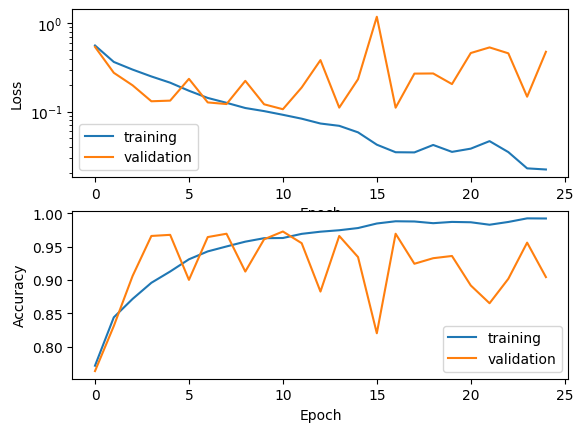

In [78]:
metrics = history_val_v1.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [79]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [81]:
y_pred = np.argmax(model_P2_v1.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

38/38 [==============================] - 1s 7ms/step
Test set accuracy: 90%


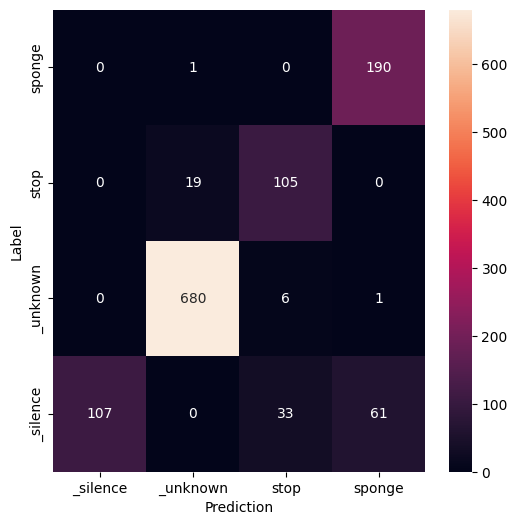

In [82]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

On training set:
675/675 [==============================] - 2s 2ms/step
Data set accuracy: 84%


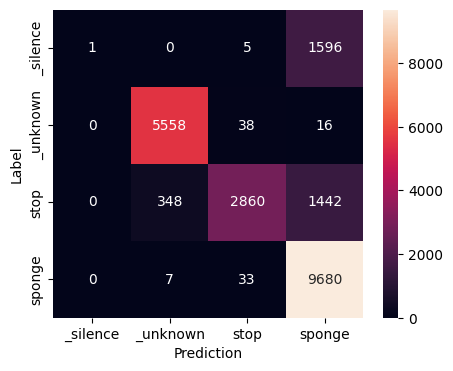

In [85]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
  ds_audio.append(audio.numpy())
  ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model.predict(ds_audio)
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Processing 4 files
Added 1 silent wavs and ?? noisy wavs
About to create spectrograms from 5 waves
 0 wavs processed

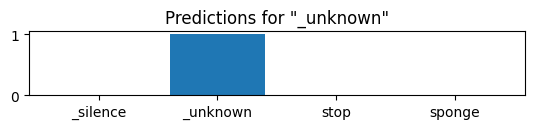

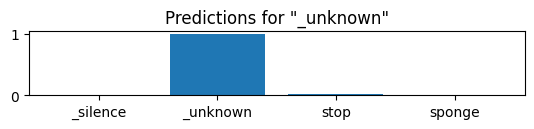

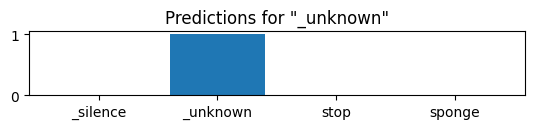

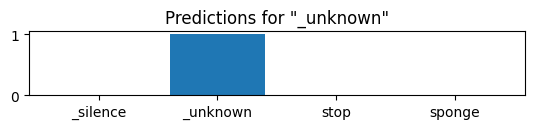

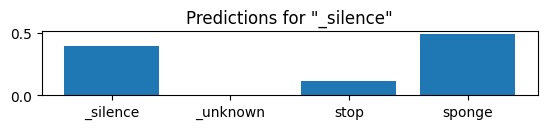

In [86]:
sample_files = [data_dir/'left/07ad9b59_nohash_0.wav', 
                data_dir/'no/01bb6a2a_nohash_0.wav',  
                data_dir/'right/0362539c_nohash_1.wav',
                data_dir/'right/b5d1e505_nohash_0.wav']
fstr_list = [str(f) for f in sample_files]
sample_ds = preprocess_dataset(fstr_list, num_silent=1)
count = 1
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.subplot(len(sample_files)+1, 1, count)
  plt.bar(label_list, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{label_list[label[0]]}"')
  plt.show()
  count += 1

## Quantize and Convert to TFLite

In [87]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [88]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [89]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [90]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\micha\AppData\Local\Temp\tmpgd6rzunu\assets


INFO:tensorflow:Assets written to: C:\Users\micha\AppData\Local\Temp\tmpgd6rzunu\assets
c:\Users\micha\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [91]:
fname = 'kws_model.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 50464 / 50464 bytes to tflite file


In [92]:
%xxd -i kws_model.tflite >! kws_model.cc

UsageError: Line magic function `%xxd` not found.


In [93]:
def convert_tflite_to_hex(model_path, output_path, bytes_per_line:int = 20):
    # opens output file
    out = open(output_path, 'w')    
    
    # counter for rolling lines over
    i = 0
    
    with open(model_path, 'rb') as data:
        while True:
            # reads the byte
            byte = data.read(1)
            if not byte:
                break
            
            i += 1
            
            # converts data to int
            value = ord(byte)
            
            # write data as hex with a comma at the end
            out.write(f"{hex(value)}, ")
            # write a new line
            if (i) % bytes_per_line == 0:
                out.write(f"\n")
            
    print(f"there are {i} bytes in the file")

In [97]:
model_title = "kws_model"

model_path  = f"{model_title}.tflite" # Path to TFLite model
output_path = f"{model_title}.txt" # Path to output hex file

if os.path.exists(output_path):
    os.remove(output_path)

convert_tflite_to_hex(model_path, output_path)


there are 50464 bytes in the file
